In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from glob import glob
import seaborn as sns
import numpy as np

sns.set()

In [2]:
all_dfs = []
for f in glob('../data/*.json'):
    all_dfs.append(pd.read_json(open(f)))
df = pd.concat(all_dfs)

In [3]:
def output_nlines(output):
    return len(set(sum([list(range(rng['start_line'], rng['end_line']+1)) for rng in output], [])))
df['nlines'] = df.output.map(output_nlines)

def function_nlines(rng):
    return len(range(rng['start_line'], rng['end_line']+1))
df['func_nlines'] = df.function_range.map(function_nlines)

df['slice_offset'] = df.apply(lambda row: row.slice['start_line'] - row.function_range['start_line'], axis=1)

In [4]:
df['slice_key'] = df.slice.map(lambda s: hash(frozenset(s.items())))

In [5]:
deltas = df.groupby('slice_key', as_index=False).apply(lambda g: pd.DataFrame([{
    'delta': g[g['mode'] == 'LikeC'].iloc[0].nlines - g[g['mode'] == 'Standard'].iloc[0].nlines,
    'orig_size': g[g['mode'] == 'Standard'].iloc[0].nlines,
    'slice': g.iloc[0].slice,
    'func_size': g.iloc[0].func_nlines,
    'slice_offset': g.iloc[0].slice_offset,
    'func_path': g.iloc[0].function_path
}]))
deltas

,,delta,orig_size,slice,func_size,slice_offset,func_path
0,0,0,1,"{'start_line': 925, 'start_col': 8, 'end_line'...",109,70,rg3d[8787]::scene::{impl#3}::draw_segment_capsule
1,0,0,6,"{'start_line': 27650, 'start_col': 12, 'end_li...",12,5,rg3d[8787]::renderer::framework::gl::ProgramUn...
2,0,0,2,"{'start_line': 985, 'start_col': 8, 'end_line'...",247,20,rg3d[8787]::renderer::{impl#12}::render_frame
3,0,0,0,"{'start_line': 1188, 'start_col': 8, 'end_line...",97,2,rg3d[8787]::scene::{impl#10}::from_file
4,0,0,15,"{'start_line': 129, 'start_col': 20, 'end_line...",92,46,rg3d[8787]::renderer::ssao::{impl#1}::new
...,...,...,...,...,...,...,...
3424,0,0,6,"{'start_line': 21847, 'start_col': 12, 'end_li...",12,5,rg3d[8787]::renderer::framework::gl::GetIntege...
3425,0,0,1,"{'start_line': 36, 'start_col': 8, 'end_line':...",13,2,rg3d[8787]::renderer::forward_renderer::{impl#...
3426,0,24,119,"{'start_line': 410, 'start_col': 12, 'end_line...",194,183,rg3d[8787]::utils::lightmap::{impl#7}::new
3427,0,0,2,"{'start_line': 578, 'start_col': 16, 'end_line...",46,12,rg3d[8787]::scene::{impl#3}::draw_sphere


In [6]:
deltas_by_func = deltas.groupby('func_path').delta.mean()
len(deltas_by_func[deltas_by_func > 0])

82

In [7]:
for i in range(10):
    x = deltas.sort_values(['delta', 'orig_size']).iloc[-(i+1)]
    print('orig_size', x.orig_size, 'delta', x.delta)
    print(f'{x.slice["filename"]}\n{x.func_path}:{x.slice["start_line"]+1}\n')

orig_size 4 delta 163
/Users/will/Code/rust-slicer/data/repos/rg3d/src/utils/lightmap.rs
rg3d[8787]::utils::lightmap::generate_lightmap:813

orig_size 4 delta 163
/Users/will/Code/rust-slicer/data/repos/rg3d/src/utils/lightmap.rs
rg3d[8787]::utils::lightmap::generate_lightmap:813

orig_size 30 delta 153
/Users/will/Code/rust-slicer/data/repos/rg3d/src/renderer/mod.rs
rg3d[8787]::renderer::{impl#12}::render_frame:1068

orig_size 4 delta 121
/Users/will/Code/rust-slicer/data/repos/rg3d/src/utils/lightmap.rs
rg3d[8787]::utils::lightmap::generate_lightmap:812

orig_size 4 delta 121
/Users/will/Code/rust-slicer/data/repos/rg3d/src/utils/lightmap.rs
rg3d[8787]::utils::lightmap::generate_lightmap:812

orig_size 4 delta 121
/Users/will/Code/rust-slicer/data/repos/rg3d/src/utils/lightmap.rs
rg3d[8787]::utils::lightmap::generate_lightmap:811

orig_size 4 delta 120
/Users/will/Code/rust-slicer/data/repos/rg3d/src/utils/lightmap.rs
rg3d[8787]::utils::lightmap::generate_lightmap:769

orig_size 4 de

In [8]:
deltas['func_bin'] = deltas.func_size // 20 * 20

<AxesSubplot:xlabel='func_bin', ylabel='delta'>

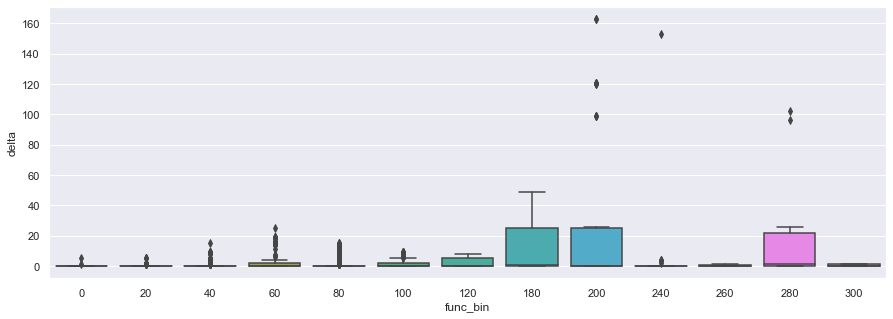

In [9]:
plt.figure(figsize=(15, 5))
deltas_filtered = deltas[(deltas.slice_offset > 10) & (deltas.func_bin < 400)]
sns.boxplot(data=deltas_filtered, x='func_bin', y='delta', )

In [10]:
deltas_filtered.groupby('func_bin').delta.describe()[['count', '50%', 'mean', 'std']]

,count,50%,mean,std
func_bin,,,,
0,69.0,0.0,0.086957,0.612111
20,98.0,0.0,0.306122,0.946052
40,289.0,0.0,0.816609,1.926857
60,157.0,0.0,2.662420,5.592525
80,233.0,0.0,1.459227,3.459035
100,196.0,0.0,1.566327,2.271493
120,87.0,0.0,2.137931,2.588761
180,26.0,0.5,13.038462,16.462031
200,49.0,0.0,30.877551,49.022373
